In [1]:
import pandas as pd 
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
#Core models
import spacy
import en_core_sci_sm
import en_core_sci_md
#NER specific models
import en_ner_bc5cdr_md
#Tools for extracting & displaying data
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
nlp = spacy.load("en_core_web_sm")

In [13]:
df = pd.read_csv('/Users/partha/Desktop/Flask_WEB/patient_details.csv')

In [14]:
doc = df[' Description']
data = []
text = []
for i in range(len(doc)):
    data = doc[i].split(", ", 3)
    text.append(data)

In [15]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [16]:
entity_pairs_diseases = []
entity_pairs_symptoms = []
entity_pairs_drugs = []
for i in range(len(text)):
  for j in tqdm(text[i]):
    entity_pairs_diseases.append(get_entities(j))



100%|██████████| 2/2 [00:00<00:00, 91.10it/s]


In [17]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

relations = []
rel=[]
for i in range(len(text)):
  for j in tqdm(text[i]):
    relations.append(get_relation(j))

for rels in relations:
        if rels not in rel:
            rel.append(rels)
print(rel)

100%|██████████| 2/2 [00:00<00:00, 100.38it/s]

['diagnosed', 'affected by', 'recommended', 'given']


In [18]:
source = [i[0] for i in entity_pairs_diseases]

# extract object
target = [i[1] for i in entity_pairs_diseases]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

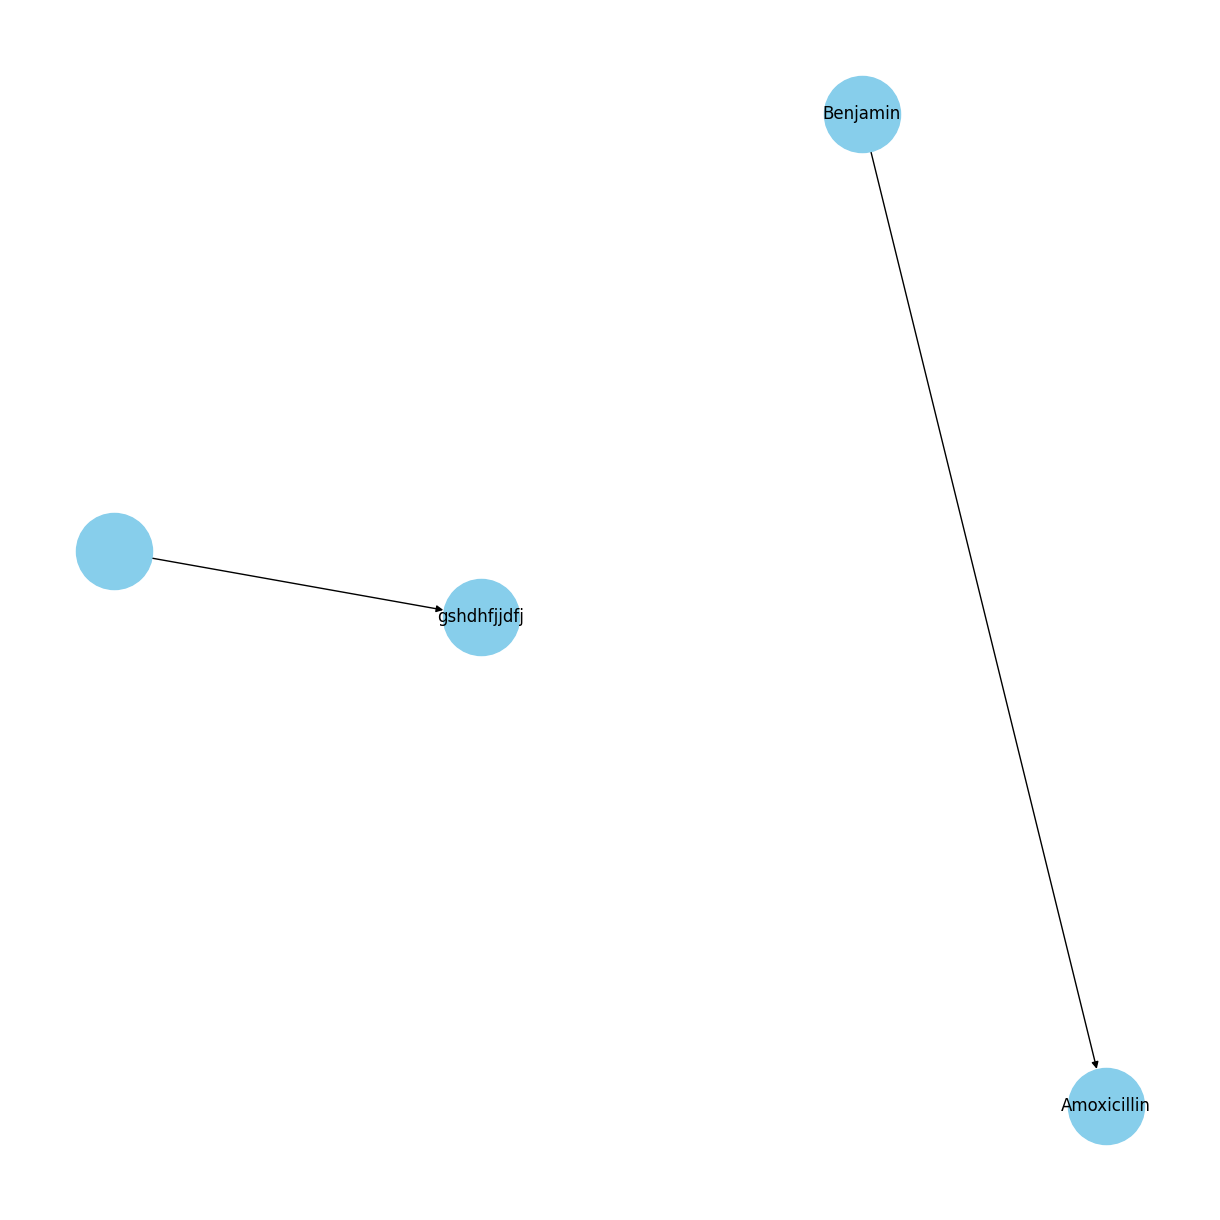

In [19]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="given"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
